<a href="https://colab.research.google.com/github/hamzaodeh/Group-A-DLI-Assignment/blob/main/CNN(Hamza).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **References**
Paper: https://www.mdpi.com/2079-9292/14/1/67

Paper's code: https://github.com/fatemehm/SECIoHT-FL-based-IDS

GitHub: https://github.com/gptchat12370-ai/Group-A-DLI-Assignment/blob/main/CNN(Hamza).ipynb

### Cell 1: Setup, Imports, Seeds, and Hyperparameters

This cell initializes the environment and sets up the necessary components for the federated learning with differential privacy (DP) experiment.

1.  **Install Opacus:** It first checks if the `opacus` library is installed and installs it if necessary. Opacus is a PyTorch library for training models with DP.
2.  **Import Libraries:** It imports essential libraries like `torch` for deep learning, `numpy` and `pandas` for data manipulation, `sklearn` for data splitting and evaluation metrics, `tqdm` for progress bars, and components from `opacus`.
3.  **Reproducibility:** Sets random seeds for `random`, `numpy`, and `torch` to ensure the results are reproducible.
4.  **Device Configuration:** Detects and sets the device to GPU (`cuda`) if available, otherwise defaults to CPU.
5.  **Hyperparameters:** Defines key hyperparameters for the federated learning and DP setup, including:
    *   `NUM_CLIENTS`: The number of simulated clients in the federated learning setup.
    *   `ROUNDS`: The number of communication rounds between the clients and the server.
    *   `BATCH`: The batch size used for training on each client. This is the "physical" batch size for DP via Poisson sampling.
    *   `NOISE`: The noise multiplier for differential privacy. A higher value means more noise and stronger privacy guarantees, but can impact model performance.
    *   `CLIP`: The maximum gradient norm for gradient clipping, another key component of DP training.
    *   `LR`: The learning rate for the AdamW optimizer.
    *   `WEIGHT_DECAY`: The weight decay for the AdamW optimizer.
    *   `LABEL_SMOOTH`: Label smoothing applied to the loss function.

This cell provides the foundational setup and configurable parameters for the entire training process.

In [2]:
# --- Cell 1: setup, imports, seeds, hyperparams ---

# (If Opacus isn't present)
!pip install opacus==1.4.0

import os, time, random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score
)
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from opacus import PrivacyEngine
from opacus.utils.uniform_sampler import UniformWithReplacementSampler

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

# --- Federated + DP hyperparams you can tune ---
NUM_CLIENTS   = 2
ROUNDS        = 35         # fewer, better rounds usually help under DP
BATCH         = 256        # DP "physical" batch via Poisson sampling
NOISE         = 0.5        # DP noise multiplier (0.3–0.5 good starting range)
CLIP          = 1.0        # DP max grad norm
LR            = 1e-3       # AdamW LR
WEIGHT_DECAY  = 1e-4
LABEL_SMOOTH  = 0.0        # leave 0.0 for accuracy; >0 can improve recall but drop acc

print(f"[Info] hyperparams: rounds={ROUNDS}, batch={BATCH}, noise={NOISE}, clip={CLIP}, lr={LR}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 5.1 MB/s eta 0:00:00
Device: cpu
[Info] hyperparams: rounds=35, batch=256, noise=0.5, clip=1.0, lr=0.001


### Cell 2: Load and Basic Data Cleaning

This cell is responsible for loading the dataset and performing initial cleaning steps.

1.  **Load Data:** It loads the data from the specified CSV file (`/content/wustl-ehms-2020_with_attacks_categories.csv`) into a pandas DataFrame. It also includes an assertion to ensure the file exists.
2.  **Select Numeric Columns:** It identifies and keeps only the columns that contain numerical data.
3.  **Handle 'Label' Column:** It specifically checks for the "Label" column and ensures it's included even if it's not initially detected as a number (as labels are often integers).
4.  **Drop Missing Values:** It removes any rows that contain missing values (`NaN`) after selecting the numeric columns.
5.  **Reorder Columns:** It explicitly moves the "Label" column to the last position in the DataFrame, which is often a convenient format for machine learning tasks where the target variable is the last column.
6.  **Print Information:** Prints the names of the columns in the cleaned DataFrame and its shape (number of rows and columns) to provide a summary of the data after cleaning.
7.  **Detect Input Features:** Calculates and prints the number of input features, which is the total number of columns minus the "Label" column.

This cell prepares the raw data by selecting relevant features, handling missing values, and structuring it for the subsequent steps.

In [3]:
# --- Cell 2: load & basic clean (keep only numeric + Label, no NAs) ---

csv_file = "/content/wustl-ehms-2020_with_attacks_categories.csv"
assert os.path.exists(csv_file), f"CSV not found at: {csv_file}"

df = pd.read_csv(csv_file)

# Keep only numeric columns and ensure 'Label' exists and is last
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if "Label" not in numeric_cols and "Label" in df.columns:
    numeric_cols.append("Label")

df = df[numeric_cols].dropna().reset_index(drop=True)

# Move Label to last column (explicit)
if df.columns[-1] != "Label":
    cols = [c for c in df.columns if c != "Label"] + ["Label"]
    df = df[cols]

print("Columns:", list(df.columns))
print("Shape after cleaning:", df.shape)

# Detect feature size
input_features = df.shape[1] - 1
print(f"[Info] input_features={input_features}")


Columns: ['Dport', 'SrcBytes', 'DstBytes', 'SrcLoad', 'DstLoad', 'SrcGap', 'DstGap', 'SIntPkt', 'DIntPkt', 'SIntPktAct', 'DIntPktAct', 'SrcJitter', 'DstJitter', 'sMaxPktSz', 'dMaxPktSz', 'sMinPktSz', 'dMinPktSz', 'Dur', 'Trans', 'TotPkts', 'TotBytes', 'Load', 'Loss', 'pLoss', 'pSrcLoss', 'pDstLoss', 'Rate', 'Packet_num', 'Temp', 'SpO2', 'Pulse_Rate', 'SYS', 'DIA', 'Heart_rate', 'Resp_Rate', 'ST', 'Label']
Shape after cleaning: (16318, 37)
[Info] input_features=36


### Cell 3: Stratified Train/Validation/Test Split and Scaling

This cell handles the splitting of the data into training, validation, and testing sets, and performs feature scaling.

1.  **`DatasetLoader` Class:** Defines a class `DatasetLoader` to encapsulate the data splitting and scaling logic.
    *   The constructor takes the DataFrame and desired fractions for train, validation, and test sets as input.
    *   It asserts that the sum of the fractions is approximately 1.0.
    *   It extracts the features (`X`) and labels (`y`) from the DataFrame.
    *   **Stratified Splitting:** It uses `train_test_split` from `sklearn` to split the data in a stratified manner. Stratification ensures that the proportion of each class (normal vs. attack) is maintained in each split (train, validation, and test), which is crucial for imbalanced datasets.
        *   First, it splits the data into a combined training/validation set and a test set.
        *   Then, it splits the combined training/validation set into separate training and validation sets.
    *   **Scaling:** It initializes a `StandardScaler` from `sklearn`.
        *   It *fits* the scaler only on the training data (`X_train`). This is important to prevent data leakage from the validation or test sets into the scaling process.
        *   It then *transforms* the training, validation, and test sets using the scaler fitted on the training data.
    *   The scaled data and corresponding labels are stored as properties (`X_train`, `y_train`, etc.).
2.  **Create `DatasetLoader` Instance:** An instance of the `DatasetLoader` class is created with the cleaned DataFrame and the defined split fractions.
3.  **Print Sizes:** Prints the number of samples in the training, validation, and test sets to confirm the split sizes.

This cell ensures that the data is properly partitioned for training, evaluating, and testing the model, and that the features are scaled appropriately based only on the training data.

In [4]:
# --- Cell 3: stratified train/val/test split + scale on train only ---

class DatasetLoader:
    def __init__(self, df, train_frac=0.7, val_frac=0.1, test_frac=0.2, seed=42):
        assert abs(train_frac + val_frac + test_frac - 1.0) < 1e-6
        self.seed = seed

        y_all = df["Label"].astype(int).values
        X_all = df.drop(columns=["Label"]).astype(np.float32).values

        # Stratified train/test
        X_trainval, X_test, y_trainval, y_test = train_test_split(
            X_all, y_all, test_size=test_frac, stratify=y_all, random_state=seed
        )
        # Stratified train/val
        val_size = val_frac / (train_frac + val_frac)
        X_train, X_val, y_train, y_val = train_test_split(
            X_trainval, y_trainval, test_size=val_size, stratify=y_trainval, random_state=seed
        )

        # Scale on train only
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train).astype(np.float32)
        X_val   = scaler.transform(X_val).astype(np.float32)
        X_test  = scaler.transform(X_test).astype(np.float32)

        self._X_train, self._y_train = X_train, y_train
        self._X_val,   self._y_val   = X_val,   y_val
        self._X_test,  self._y_test  = X_test,  y_test

    @property
    def X_train(self): return self._X_train
    @property
    def y_train(self): return self._y_train
    @property
    def X_val(self):   return self._X_val
    @property
    def y_val(self):   return self._y_val
    @property
    def X_test(self):  return self._X_test
    @property
    def y_test(self):  return self._y_test

dloader = DatasetLoader(df, train_frac=0.7, val_frac=0.1, test_frac=0.2, seed=SEED)
print("Train/Val/Test sizes:", len(dloader.X_train), len(dloader.X_val), len(dloader.X_test))


Train/Val/Test sizes: 11422 1632 3264


### Cell 4: Build Client DP Loaders and Standard Val/Test Loaders

This cell prepares the data loaders for the federated learning setup, specifically focusing on creating differentially private data loaders for each client using Opacus.

1.  **`split_clients` Function:** Defines a helper function to split the training data (`X`, `y`) into `num_clients` parts. This simulates the data distribution across different clients in a federated learning scenario. The data is split sequentially.
2.  **Split Training Data:** The `split_clients` function is called to divide the training data (`dloader.X_train`, `dloader.y_train`) among the specified number of clients (`NUM_CLIENTS`).
3.  **Calculate Class Weights:** Computes class weights to address potential class imbalance in the training data. It calculates the ratio of negative samples (normal) to positive samples (attack) and caps the weight for the attack class to a maximum of 5.0 to prevent excessive boosting which could lead to unstable training. This weighted loss function helps the model pay more attention to the minority class.
4.  **`make_dp_client_loader` Function:** Defines a function to create a differentially private data loader for a given client's data split.
    *   It converts the client's data (`Xc`, `yc`) into PyTorch tensors.
    *   It creates a `TensorDataset` from the tensors.
    *   It calculates the sample rate based on the batch size (`BATCH`) and the total number of samples for the client.
    *   It uses `UniformWithReplacementSampler` from `opacus.utils.uniform_sampler`. This sampler is crucial for DP training as it samples data points with replacement, allowing Opacus to provide privacy guarantees.
    *   It returns a `DataLoader` configured with the sampler and the total number of samples for the client.
5.  **Create Client Loaders:** A dictionary `client_loaders` is created, where each key is a client name (e.g., "client_0") and the value is the DP data loader for that client's data split. The corresponding number of samples for each client is stored in the `client_sizes` dictionary.
6.  **Create Standard Val/Test Loaders:** Standard PyTorch `DataLoader`s are created for the validation and test sets. These loaders do *not* use DP as evaluation is typically done without privacy constraints.
7.  **Print Information:** Prints the number of batches in each client loader, the validation loader, and the test loader to show the data distribution for training and evaluation.

This cell sets up the data pipelines for the federated learning process, ensuring that client training incorporates differential privacy through Opacus's specialized data loaders.

In [5]:
# --- Cell 4: build client DP loaders + val/test loaders ---

def split_clients(X, y, num_clients):
    n = len(X)
    per = n // num_clients
    splits = []
    for i in range(num_clients):
        s = i*per
        e = (i+1)*per if i < num_clients-1 else n
        splits.append((X[s:e], y[s:e]))
    return splits

client_splits = split_clients(dloader.X_train, dloader.y_train, NUM_CLIENTS)

# Class weights (boost minority class)
pos = (dloader.y_train == 1).sum()
neg = (dloader.y_train == 0).sum()
pos_weight = max(1.0, min(5.0, neg / max(1, pos)))  # cap to [1,5] to avoid exploding gradients
CLASS_WEIGHTS_TENSOR = torch.tensor([1.0, pos_weight], dtype=torch.float32, device=device)
print(f"[Info] class weights: normal=1.0, attack={pos_weight:.2f}")

# Poisson-sampled DP loader for each client (required by Opacus)
def make_dp_client_loader(Xc, yc, batch_size=BATCH):
    Xc_t = torch.tensor(Xc, dtype=torch.float32)
    yc_t = torch.tensor(yc, dtype=torch.long)
    ds = TensorDataset(Xc_t, yc_t)
    N = len(ds)
    sample_rate = batch_size / float(N)
    sampler = UniformWithReplacementSampler(num_samples=N, sample_rate=sample_rate)
    return DataLoader(ds, batch_sampler=sampler, num_workers=1, pin_memory=False), N

client_loaders = {}
client_sizes   = {}
for i, (Xc, yc) in enumerate(client_splits):
    ld, N = make_dp_client_loader(Xc, yc, batch_size=BATCH)
    client_loaders[f"client_{i}"] = ld
    client_sizes[f"client_{i}"]   = N

# Val & Test standard loaders
val_loader = DataLoader(
    TensorDataset(torch.tensor(dloader.X_val, dtype=torch.float32),
                  torch.tensor(dloader.y_val, dtype=torch.long)),
    batch_size=BATCH, shuffle=False, num_workers=1, pin_memory=False
)
test_loader = DataLoader(
    TensorDataset(torch.tensor(dloader.X_test, dtype=torch.float32),
                  torch.tensor(dloader.y_test, dtype=torch.long)),
    batch_size=BATCH, shuffle=False, num_workers=1, pin_memory=False
)

print("[Info] clients:", {k: len(v) for k, v in client_loaders.items()},
      "| val batches:", len(val_loader), "| test batches:", len(test_loader))


[Info] class weights: normal=1.0, attack=5.00
[Info] clients: {'client_0': 22, 'client_1': 22} | val batches: 7 | test batches: 13


### Cell 5: DP-safe CNN Model Definition

This cell defines the Convolutional Neural Network (CNN) model architecture designed to be compatible with Differential Privacy (DP) training using Opacus.

1.  **`CNN` Class:** Defines a PyTorch `nn.Module` class named `CNN`.
2.  **Initialization (`__init__`)**:
    *   Takes `input_features` (the number of features in each data sample) and `num_classes` (the number of output classes, which is 2 for binary classification) as input.
    *   **Convolutional Layers:** Defines two 1D convolutional layers (`conv1` and `conv2`). 1D convolutions are suitable for processing sequential or time-series-like data, which is how the input features are treated here. `bias=True` is used, which is compatible with Opacus.
    *   **Group Normalization:** Defines two `GroupNorm` layers (`gn1` and `gn2`). **Crucially, `GroupNorm` is used instead of `BatchNorm`**. This is because `BatchNorm` statistics are dependent on the batch data, which can leak information in a DP setting. `GroupNorm` normalizes features within groups independently of the batch size, making it DP-compatible.
    *   **Max Pooling:** Defines two `MaxPool1d` layers (`pool1` and `pool2`) to reduce the spatial dimensions after the convolutional layers.
    *   **Linear Layers:** Defines two fully connected (linear) layers (`fc1` and `fc2`).
    *   **Dropout:** Includes a `Dropout` layer (`drop`) for regularization to prevent overfitting.
3.  **Forward Pass (`forward`)**:
    *   Takes the input tensor `x`.
    *   `x.unsqueeze(1)`: Adds a channel dimension to the input, changing the shape from `[batch_size, features]` to `[batch_size, 1, features]`, which is the expected input format for `Conv1d`.
    *   The data then passes through the convolutional, GroupNorm, ReLU activation, and max pooling layers sequentially.
    *   `x.flatten(1)`: Flattens the output of the convolutional and pooling layers into a single dimension per sample before feeding it to the linear layers.
    *   Passes through the first linear layer (`fc1`) with GELU activation (a common alternative to ReLU).
    *   Applies dropout (`drop`).
    *   Passes through the final linear layer (`fc2`) to produce the raw output logits for each class.

This cell defines the neural network architecture, specifically choosing components like `GroupNorm` to ensure compatibility with the differential privacy mechanisms provided by Opacus.

In [6]:
# --- Cell 5: DP-safe CNN (1D) with GroupNorm (no BatchNorm!) ---

class CNN(nn.Module):
    def __init__(self, input_features: int, num_classes: int = 2):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1, bias=True)
        self.gn1   = nn.GroupNorm(16, 64)
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1, bias=True)
        self.gn2   = nn.GroupNorm(16, 128)
        self.pool2 = nn.MaxPool1d(2)

        L = input_features // 4  # after two pool(2) layers
        self.fc1 = nn.Linear(128 * L, 192)
        self.drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(192, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)                # [B,F]→[B,1,F]
        x = self.pool1(F.relu(self.gn1(self.conv1(x))))
        x = self.pool2(F.relu(self.gn2(self.conv2(x))))
        x = x.flatten(1)
        x = F.gelu(self.fc1(x))
        x = self.drop(x)
        return self.fc2(x)                # logits


### Cell 6: Server and Client Implementations with Opacus DP

This cell defines the `Server` and `Client` classes that orchestrate the federated learning process with Differential Privacy integrated using Opacus.

1.  **Hyperparameter Reminders:** Re-states the DP-related hyperparameters (`NOISE`, `CLIP`, `LR`, `WEIGHT_DECAY`, `LABEL_SMOOTH`) from Cell 1 for clarity within this cell.
2.  **`Server` Class:** Represents the central server that aggregates model updates from clients.
    *   **Initialization (`__init__`)**: Takes a `model` (the global model) as input. It also initializes lists to store client parameters and their data sizes.
    *   `parameters` and `model` properties: Provide access to the server's model parameters and the model itself.
    *   `add_client_parameters`: Stores the parameters received from a client along with the number of samples that client trained on.
    *   `aggregate_parameters`: Performs the federated aggregation.
        *   Calculates the total number of samples across all clients.
        *   Scales each client's parameters by their data size divided by the total size (weighted averaging).
        *   Sums the scaled parameters from all clients to get the aggregated update.
        *   Updates the server's model parameters with the aggregated values.
        *   Clears the stored client parameters and sizes.
3.  **`Client` Class:** Represents a single client participating in the federated learning.
    *   **Initialization (`__init__`)**: Takes a `train_loader` (the client's DP data loader) and `input_features` as input.
        *   Initializes a local `CNN` model with the specified input features and number of classes (2).
        *   Initializes an `AdamW` optimizer for the local model.
        *   Initializes a `CrossEntropyLoss` criterion, using the calculated class weights (`CLASS_WEIGHTS_TENSOR`) and label smoothing.
        *   **Opacus Integration:** Creates a `PrivacyEngine` instance and uses its `make_private` method to wrap the model, optimizer, and data loader. This is the core step for applying DP. It configures the privacy engine with the specified `noise_multiplier` and `max_grad_norm`. The `secure_mode=False` is used for faster experimentation.
    *   `parameters` property: Provides access to the client's local model parameters.
    *   `update_from_server`: Updates the client's local model parameters with the aggregated parameters received from the server.
    *   `train_one_epoch`: Trains the client's local model for one epoch.
        *   Sets the model to training mode (`self._model.train()`).
        *   Iterates through the client's `train_loader`.
        *   Performs a standard PyTorch training step: forward pass, calculate loss, zero gradients, backward pass, and optimizer step. Opacus automatically handles adding noise and clipping gradients during the `backward()` and `step()` calls.
        *   Appends the loss to a list.
        *   After the epoch, it uses `privacy_engine.get_epsilon()` to calculate the spent privacy budget (epsilon) for the client based on the training steps and parameters.
        *   Prints the client name, epoch number, average loss, and the calculated epsilon.

This cell provides the core logic for the federated learning simulation, defining how the server aggregates updates and how each client trains locally while preserving privacy using Opacus.

In [7]:
# --- Cell 6: Server & Client with Opacus DP ---

NOISE = NOISE        # from Cell 1 (just keeping visibility)
CLIP  = CLIP
LR    = LR
WEIGHT_DECAY = WEIGHT_DECAY
LABEL_SMOOTH = LABEL_SMOOTH

class Server:
    def __init__(self, model):
        self._model = model
        self._client_params = []
        self._client_sizes  = []
    @property
    def parameters(self): return self._model.parameters()
    @property
    def model(self): return self._model
    def add_client_parameters(self, parameters, num_samples):
        self._client_params.append([p.detach().clone().to(device) for p in parameters])
        self._client_sizes.append(num_samples)
    def aggregate_parameters(self):
        total = float(sum(self._client_sizes))
        scaled = []
        for plist, n in zip(self._client_params, self._client_sizes):
            w = n / total
            scaled.append([w * p for p in plist])
        agg = [torch.zeros_like(t) for t in scaled[0]]
        for plist in scaled:
            for j, t in enumerate(plist):
                agg[j] += t
        with torch.no_grad():
            for mp, newp in zip(self._model.parameters(), agg):
                mp.data = newp.data.clone()
        self._client_params.clear()
        self._client_sizes.clear()

class Client:
    def __init__(self, train_loader, input_features: int):
        self._model = CNN(input_features=input_features, num_classes=2).to(device)
        self._opt   = optim.AdamW(self._model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
        self._loss  = nn.CrossEntropyLoss(weight=CLASS_WEIGHTS_TENSOR, label_smoothing=LABEL_SMOOTH)
        self.train_loader = train_loader
        self.privacy_engine = PrivacyEngine(secure_mode=False)
        self._model, self._opt, self.train_loader = self.privacy_engine.make_private(
            module=self._model,
            optimizer=self._opt,
            data_loader=self.train_loader,
            noise_multiplier=NOISE,
            max_grad_norm=CLIP,
        )
    @property
    def parameters(self): return self._model.parameters()
    def update_from_server(self, server_params):
        with torch.no_grad():
            for my_p, srv_p in zip(self._model.parameters(), server_params):
                my_p.data = srv_p.detach().clone()
    def train_one_epoch(self, epoch: int, name: str):
        self._model.train()
        losses = []
        for xb, yb in self.train_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = self._model(xb)
            loss = self._loss(logits, yb)
            self._opt.zero_grad()
            loss.backward()
            self._opt.step()
            losses.append(loss.item())
        eps = self.privacy_engine.get_epsilon(1e-4)
        print(f"Client: {name:>8}  Epoch: {epoch:02d}  Loss: {np.mean(losses):.6f}  (ε={eps:.2f})")


### Cell 7: Training Loop with Best Validation Snapshot and Threshold Tuning

This cell implements the main federated learning training loop, including client training, server aggregation, validation, model snapshotting, and tuning the decision threshold on the validation set.

1.  **`infer_probs` Function:** A helper function to get the predicted probabilities and true labels from a model on a given data loader.
    *   Sets the model to evaluation mode (`model.eval()`).
    *   Iterates through the loader without calculating gradients (`torch.no_grad()`).
    *   Performs a forward pass and collects the output logits and true labels.
    *   Applies the softmax function to convert logits to probabilities.
    *   Returns the probabilities and true labels as NumPy arrays.
2.  **Initialize Clients and Server:** Creates instances of the `Client` and `Server` classes, passing the appropriate data loaders and model architecture.
3.  **Training Loop:** Iterates for the specified number of `ROUNDS`.
    *   **Server Snapshot:** Before sending parameters to clients, a snapshot of the server's current model parameters is taken.
    *   **Client Training:** For each client:
        *   The client's model is updated with the server's snapshot parameters (`cl.update_from_server`).
        *   The client trains its model for one epoch (`cl.train_one_epoch`). Opacus handles the DP aspects during this training.
        *   The client's updated parameters and the number of samples it trained on are sent to the server (`server.add_client_parameters`).
    *   **Server Aggregation:** After all clients have trained and sent their updates, the server aggregates the client parameters to update its global model (`server.aggregate_parameters`).
    *   **Validation:** After aggregation in each round:
        *   The `infer_probs` function is used to get predictions on the validation set.
        *   The accuracy is calculated using a default threshold of 0.5 for a quick check of training progress.
        *   The validation accuracy is printed.
    *   **Best Model Snapshot:** If the current validation accuracy is better than the best accuracy seen so far, the current server model's parameters are saved as the `best_snapshot`.
4.  **Restore Best Model:** After the training loop finishes, the server's model is loaded with the parameters from the `best_snapshot` (the model that achieved the highest accuracy on the validation set during training).
5.  **Threshold Tuning:**
    *   A range of possible decision thresholds (`ths`) from 0.01 to 0.99 is defined.
    *   The `infer_probs` function is used again to get probabilities on the validation set using the best model.
    *   The accuracy is calculated for each threshold in `ths`.
    *   The threshold that yields the highest accuracy on the validation set is selected as `best_t`.
    *   The `best_t` is printed.

This cell drives the federated learning process round by round, incorporating DP training on clients, server aggregation, and using the validation set to select the best model and its optimal decision threshold.

In [8]:
# --- Cell 7: training loop with best-val snapshot + threshold tuning on validation ---

def infer_probs(model, loader):
    model.eval()
    all_logits, all_y = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            logits = model(xb)
            all_logits.append(logits.cpu())
            all_y.append(yb.cpu())
    logits = torch.cat(all_logits, 0)
    y_true = torch.cat(all_y, 0).numpy()
    probs  = F.softmax(logits, dim=1).numpy()
    return probs, y_true

# Build clients & server
clients = {name: Client(ld, input_features) for name, ld in client_loaders.items()}
server  = Server(CNN(input_features=input_features, num_classes=2).to(device))

t0 = time.time()
best_val_acc, best_round, best_snapshot = -1, -1, None

for epoch in range(ROUNDS):
    srv_params_snapshot = [p.detach().clone() for p in server.parameters]
    for name, cl in clients.items():
        cl.update_from_server(srv_params_snapshot)
        cl.train_one_epoch(epoch, name)
        server.add_client_parameters(cl.parameters, num_samples=client_sizes[name])
    server.aggregate_parameters()

    # quick val acc @ 0.5 threshold to track training
    val_probs, val_y = infer_probs(server.model, val_loader)
    val_pred_05 = (val_probs[:,1] >= 0.5).astype(int)
    val_acc = (val_pred_05 == val_y).mean()
    print(f"[Val @ epoch {epoch}] accuracy={val_acc*100:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_round = epoch
        best_snapshot = [p.detach().clone() for p in server.model.parameters()]

train_time = time.time() - t0
print(f"[Info] Best val accuracy {best_val_acc*100:.2f}% at round {best_round}")

# Restore best snapshot
with torch.no_grad():
    for mp, sp in zip(server.model.parameters(), best_snapshot):
        mp.data = sp.clone()

# Tune decision threshold on validation to maximize accuracy
ths = np.linspace(0.01, 0.99, 99)
accs = []
val_probs, val_y = infer_probs(server.model, val_loader)
for t in ths:
    accs.append(((val_probs[:,1] >= t).astype(int) == val_y).mean())
best_t = float(ths[int(np.argmax(accs))])
print(f"[Info] Best threshold (val, accuracy) = {best_t:.2f}")


/usr/local/lib/python3.12/dist-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Client: client_0  Epoch: 00  Loss: 2.465805  (ε=8.05)


/usr/local/lib/python3.12/dist-packages/opacus/accountants/analysis/prv/prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)


Client: client_1  Epoch: 00  Loss: 2.684537  (ε=8.05)
[Val @ epoch 0] accuracy=87.44%
Client: client_0  Epoch: 01  Loss: 1.721759  (ε=10.20)
Client: client_1  Epoch: 01  Loss: 1.762560  (ε=10.20)
[Val @ epoch 1] accuracy=87.44%
Client: client_0  Epoch: 02  Loss: 1.697062  (ε=11.92)
Client: client_1  Epoch: 02  Loss: 1.725030  (ε=11.92)
[Val @ epoch 2] accuracy=87.44%
Client: client_0  Epoch: 03  Loss: 1.699450  (ε=13.41)
Client: client_1  Epoch: 03  Loss: 1.675658  (ε=13.41)
[Val @ epoch 3] accuracy=87.44%
Client: client_0  Epoch: 04  Loss: 1.695631  (ε=14.77)
Client: client_1  Epoch: 04  Loss: 1.711497  (ε=14.77)
[Val @ epoch 4] accuracy=87.56%
Client: client_0  Epoch: 05  Loss: 1.566354  (ε=16.03)
Client: client_1  Epoch: 05  Loss: 1.638306  (ε=16.03)
[Val @ epoch 5] accuracy=87.50%
Client: client_0  Epoch: 06  Loss: 1.578429  (ε=17.21)
Client: client_1  Epoch: 06  Loss: 1.606298  (ε=17.21)
[Val @ epoch 6] accuracy=87.93%
Client: client_0  Epoch: 07  Loss: 1.441731  (ε=18.34)
Client:

### Cell 8: Final Evaluation on Test Set and Results Table

This cell evaluates the final trained model on the held-out test set using the decision threshold tuned on the validation set and presents the results in a table.

1.  **`evaluate_with_threshold` Function:** Defines a function to compute various classification metrics on a given loader using a specified threshold.
    *   Calls `infer_probs` to get predicted probabilities and true labels.
    *   Determines the predicted class based on whether the probability for the positive class (index 1) is greater than or equal to the provided `thr`.
    *   Calculates and prints the confusion matrix and classification report using `sklearn`.
    *   Calculates and returns the accuracy, precision, recall, F1-score, ROC AUC, predicted labels, probabilities, and true labels.
2.  **Evaluate on Test Set:** The `evaluate_with_threshold` function is called with the `test_loader` and the `best_t` (the threshold tuned on the validation set from Cell 7). This provides the final performance metrics on unseen data.
3.  **Calculate Privacy Budget:** Retrieves the total spent privacy budget (epsilon) from the privacy engine of one of the clients (since all clients train with the same DP parameters).
4.  **Create Results DataFrame:** A pandas DataFrame is created to summarize the results. It includes:
    *   Method and Algorithm names.
    *   Core classification metrics (Accuracy, Precision, Recall, F1-Score) as percentages.
    *   Training and testing times.
    *   The total privacy budget spent (epsilon).
    *   The DP and federated learning hyperparameters used (`Noise`, `Clip`, `Rounds`, `Batch`, `LR`).
    *   The tuned decision threshold (`Threshold`).
5.  **Print Results Table:** Prints the results DataFrame in a formatted string without the index.

This cell provides the final assessment of the trained model's performance on the test set, using the optimal threshold found during validation, and presents a comprehensive table summarizing the key results and hyperparameters.

In [9]:
# --- Cell 8: final evaluation on test with tuned threshold + table ---

def evaluate_with_threshold(model, loader, thr):
    probs, y = infer_probs(model, loader)
    preds = (probs[:,1] >= thr).astype(int)
    acc = accuracy_score(y, preds)
    prec = precision_score(y, preds)
    rec  = recall_score(y, preds)
    f1   = f1_score(y, preds)
    auc  = roc_auc_score(y, probs[:,1])
    print("\nConfusion matrix:\n", confusion_matrix(y, preds))
    print("\nClassification Report:\n", classification_report(y, preds))
    return acc, prec, rec, f1, auc, preds, probs, y

t1 = time.time()
acc, prec, rec, f1, auc, preds, probs, y_true = evaluate_with_threshold(server.model, test_loader, best_t)
test_time = time.time() - t1

epsilon = list(clients.values())[0].privacy_engine.get_epsilon(1e-4)

results = pd.DataFrame([{
    "Methods": "Federated + CNN (DP)",
    "Algorithm": "CNN",
    "Accuracy (%)": round(acc * 100, 2),
    "Precision (%)": round(prec * 100, 2),
    "Recall (%)": round(rec * 100, 2),
    "F1-Score (%)": round(f1 * 100, 2),
    "Train Time (s)": round(train_time, 2),
    "Test Time (s)": round(test_time, 2),
    "Privacy Budget (ε)": round(epsilon, 2),
    "Noise": NOISE,
    "Clip": CLIP,
    "Rounds": ROUNDS,
    "Batch": BATCH,
    "LR": LR,
    "Threshold": round(best_t, 2)
}])
print("\n=== Results Table ===")
print(results.to_string(index=False))



Confusion matrix:
 [[2836   19]
 [ 197  212]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96      2855
           1       0.92      0.52      0.66       409

    accuracy                           0.93      3264
   macro avg       0.93      0.76      0.81      3264
weighted avg       0.93      0.93      0.93      3264



/usr/local/lib/python3.12/dist-packages/opacus/accountants/analysis/prv/prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)



=== Results Table ===
             Methods Algorithm  Accuracy (%)  Precision (%)  Recall (%)  F1-Score (%)  Train Time (s)  Test Time (s)  Privacy Budget (ε)  Noise  Clip  Rounds  Batch    LR  Threshold
Federated + CNN (DP)       CNN         93.38          91.77       51.83         66.25          957.49           0.57               41.08    0.5   1.0      35    256 0.001       0.22


### Cell 9: Final Results, Graphs, and Comparison to Paper

This cell provides a comprehensive analysis of the final model's performance on the test set, including plotting evaluation curves, comparing metrics to a reference paper's results, and saving the output.

1.  **Import Libraries:** Imports necessary libraries for plotting and evaluation metrics, including `matplotlib.pyplot` and more functions from `sklearn.metrics`.
2.  **`predict_proba` Function:** A helper function (similar to `infer_probs` but specifically named `predict_proba` for clarity in this context) to get the predicted probabilities and true labels from a model on a given loader. It ensures the input tensor is a float type.
3.  **Get Probabilities and Labels:** Calls `predict_proba` to get the probabilities and true labels for the `test_loader`. It includes a check to reuse already computed `probs` and `y_true` if they exist from the previous cell, or computes them otherwise.
4.  **ROC Curve and Best Threshold (Youden's J):**
    *   Calculates the False Positive Rate (FPR), True Positive Rate (TPR), and thresholds for the ROC curve using `roc_curve`.
    *   Finds the best threshold based on Youden's J statistic (where TPR - FPR is maximized), which is a common way to select an optimal threshold from the ROC curve.
5.  **Calculate Final Metrics:** Calculates the final classification metrics (Accuracy, Precision, Recall, F1-Score, ROC AUC) on the test set using the best threshold determined by Youden's J.
6.  **Print Metrics:** Prints the best threshold and the calculated final metrics.
7.  **Confusion Matrix Plot:**
    *   Calculates the confusion matrix using the test set true labels and predictions based on the best threshold.
    *   Uses `ConfusionMatrixDisplay` to plot the confusion matrix.
    *   Saves the plot as a PNG file.
    *   Displays the plot.
8.  **ROC Curve Plot:**
    *   Plots the ROC curve using the calculated FPR and TPR.
    *   Adds the ROC AUC value to the legend.
    *   Saves the plot as a PNG file.
    *   Displays the plot.
9.  **Precision-Recall Curve Plot:**
    *   Calculates the precision and recall values for various thresholds using `precision_recall_curve`.
    *   Plots the Precision-Recall curve.
    *   Saves the plot as a PNG file.
    *   Displays the plot.
10. **Summary Table:** Creates a pandas DataFrame (`results_summary`) to present the final metrics and hyperparameters in a clear table format. This is similar to the table in Cell 8 but includes the ROC AUC and the threshold derived from Youden's J.
11. **Print and Save Summary:** Prints the final results summary table and saves it as a CSV file.
12. **Comparison to Paper:**
    *   Includes hardcoded metrics for a "Paper CNN (Noise=0.5)" for comparison.
    *   Creates a DataFrame comparing the paper's results to your model's results for core metrics.
    *   Calculates the difference (delta) between your model's metrics and the paper's metrics.
    *   Displays both the comparison table and the delta table.
    *   **Grouped Bar Chart:** Creates a grouped bar chart visualizing the comparison of Accuracy, Precision, Recall, and F1-Score between your model and the paper's results. Saves and displays the chart.
    *   **Confusion Matrix (Yours):** Plots the confusion matrix specifically for your model at the Youden's J threshold, saving and displaying it.
    *   **Text Summary:** Prints a concise text summary comparing your model's key metrics to the paper's, including the delta for core metrics and additional information like ROC AUC, parameters, and test time.
13. **Saved Files:** Lists the names of the image and CSV files that have been saved.

This cell provides a comprehensive visual and tabular summary of the model's performance, facilitates comparison with external benchmarks (like a paper), and saves the results for future reference.

Best threshold: 0.253
Accuracy: 93.41% | Precision: 92.17% | Recall: 51.83% | F1: 66.35% | ROC AUC: 0.8289


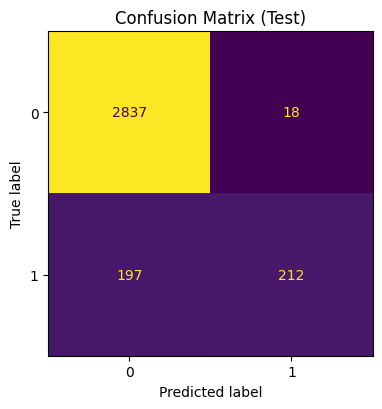

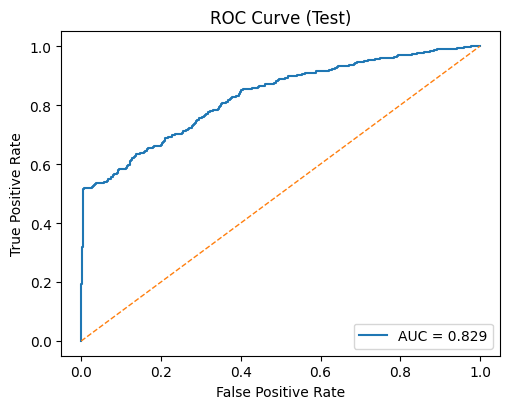

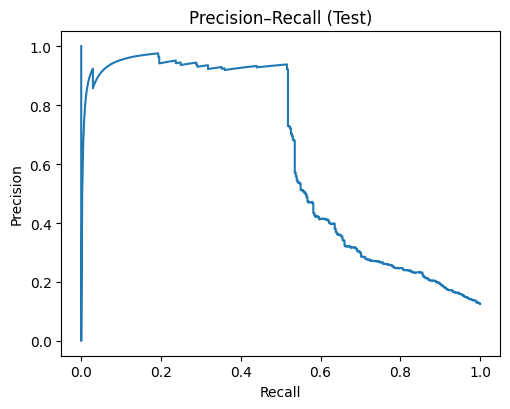


=== Final Results ===
             Methods Algorithm  Accuracy (%)  Precision (%)  Recall (%)  F1-Score (%)  ROC AUC  Threshold  Noise  Clip  Rounds  Batch    LR
Federated + CNN (DP)       CNN         93.41          92.17       51.83         66.35   0.8289      0.253    0.5   1.0      35    256 0.001

Saved: cnn_dp_confusion.png, cnn_dp_roc.png, cnn_dp_pr.png, cnn_dp_results_summary.csv


In [10]:
# === Cell: Final results & graphs ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score,
    precision_recall_curve
)

def predict_proba(model, loader):
    model.eval()
    probs, y_true = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device).float()
            logits = model(xb)
            p = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
            probs.append(p)
            y_true.append(yb.cpu().numpy())
    return np.concatenate(probs), np.concatenate(y_true)

# Get probabilities & labels
probs, y_true = predict_proba(server.model, test_loader)

# ROC + best threshold (Youden’s J)
fpr, tpr, thresholds = roc_curve(y_true, probs)
best_idx = np.argmax(tpr - fpr)
best_t = float(thresholds[best_idx])

# Final preds & metrics
y_pred = (probs >= best_t).astype(int)
acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, zero_division=0)
rec  = recall_score(y_true, y_pred, zero_division=0)
f1   = f1_score(y_true, y_pred, zero_division=0)
auc  = roc_auc_score(y_true, probs)

print(f"Best threshold: {best_t:.3f}")
print(f"Accuracy: {acc*100:.2f}% | Precision: {prec*100:.2f}% | Recall: {rec*100:.2f}% | "
      f"F1: {f1*100:.2f}% | ROC AUC: {auc:.4f}")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=[0, 1])
fig_cm, ax_cm = plt.subplots(figsize=(4.8, 4.2))
disp.plot(ax=ax_cm, colorbar=False)
ax_cm.set_title("Confusion Matrix (Test)")
plt.tight_layout()
plt.savefig("cnn_dp_confusion.png", dpi=150)
plt.show()

# ROC curve
fig_roc, ax = plt.subplots(figsize=(5.2, 4.2))
ax.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
ax.plot([0, 1], [0, 1], "--", linewidth=1)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curve (Test)")
ax.legend(loc="lower right")
plt.tight_layout()
plt.savefig("cnn_dp_roc.png", dpi=150)
plt.show()

# Precision–Recall curve
prec_curve, rec_curve, _ = precision_recall_curve(y_true, probs)
fig_pr, axp = plt.subplots(figsize=(5.2, 4.2))
axp.plot(rec_curve, prec_curve)
axp.set_xlabel("Recall")
axp.set_ylabel("Precision")
axp.set_title("Precision–Recall (Test)")
plt.tight_layout()
plt.savefig("cnn_dp_pr.png", dpi=150)
plt.show()

# Summary table
results_summary = pd.DataFrame([{
    "Methods": "Federated + CNN (DP)",
    "Algorithm": "CNN",
    "Accuracy (%)": round(acc * 100, 2),
    "Precision (%)": round(prec * 100, 2),
    "Recall (%)": round(rec * 100, 2),
    "F1-Score (%)": round(f1 * 100, 2),
    "ROC AUC": round(auc, 4),
    "Threshold": round(best_t, 3),
    "Noise": NOISE,
    "Clip": CLIP,
    "Rounds": ROUNDS,
    "Batch": BATCH,
    "LR": LR,
}])
print("\n=== Final Results ===")
print(results_summary.to_string(index=False))
results_summary.to_csv("cnn_dp_results_summary.csv", index=False)

print("\nSaved: cnn_dp_confusion.png, cnn_dp_roc.png, cnn_dp_pr.png, cnn_dp_results_summary.csv")

=== Paper vs. Your Model (Noise = 0.5 only) ===


,Model,Accuracy (%),Precision (%),Recall (%),F1-Score (%),ROC AUC,Threshold,Params (M),Test time (s)
0,Paper CNN (Noise=0.5),89.44,89.00,100.00,94.00,NaN,NaN,NaN,0.011
1,"CNN (Hamza, Noise=0.5)",93.41,92.17,51.83,66.35,0.8289,0.253,0.247,1.905


,Model,Accuracy (%),Precision (%),Recall (%),F1-Score (%),ROC AUC,Threshold,Params (M),Test time (s)
0,Δ (Hamza − Paper),3.97,3.17,-48.17,-27.65,None,None,None,1.894


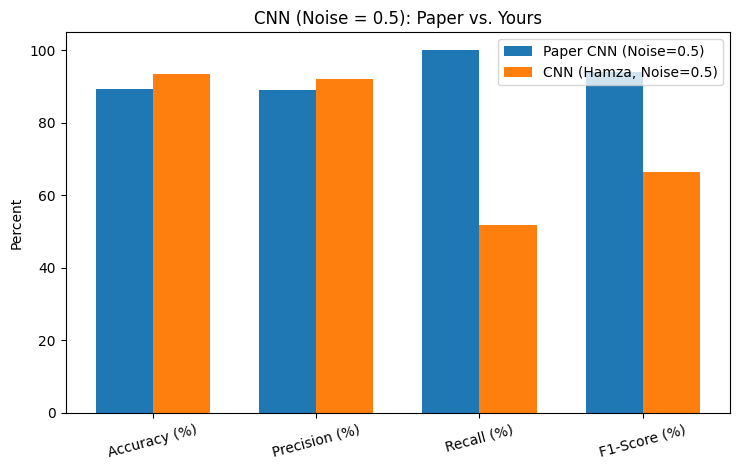

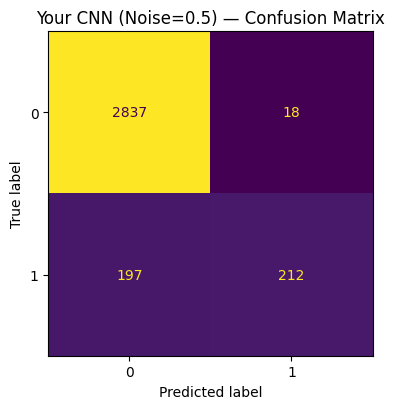


Summary (Δ = yours − paper):
 Accuracy:  93.41%  (Δ +3.97%)
 Precision: 92.17%  (Δ +3.17%)
 Recall:    51.83%  (Δ -48.17%)
 F1-Score:  66.35%  (Δ -27.65%)
 ROC AUC:   0.8289   (paper N/A)
 Params:    0.247 M   (paper N/A)
 Test time: 1.905 s (paper 0.011 s)


In [12]:
# ================================
# Compare to Paper (CNN, Noise = 0.5) — table + charts
# ================================
import numpy as np, pandas as pd, time
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
)

# ---------- Helper: get probs/labels from your model ----------
def _predict_proba_model(model, loader):
    try:
        import torch, torch.nn.functional as F
        model.eval()
        probs, y_true = [], []
        with torch.no_grad():
            for xb, yb in loader:
                xb = xb.float().to(next(model.parameters()).device)
                logits = model(xb)
                p = F.softmax(logits, dim=1)[:, 1].detach().cpu().numpy()
                probs.append(p); y_true.append(yb.numpy())
        return np.concatenate(probs), np.concatenate(y_true)
    except Exception as e:
        raise RuntimeError(f"Cannot compute predictions from model/test_loader: {e}")

# ---------- Obtain your test probabilities & labels ----------
# If `probs` and `y_true` already exist, reuse them; otherwise compute
if "probs" in globals() and "y_true" in globals():
    _probs, _y_true = probs, y_true
else:
    _probs, _y_true = _predict_proba_model(server.model, test_loader)

# ---------- Pick threshold by Youden’s J (same idea as your prior cell) ----------
fpr, tpr, ths = roc_curve(_y_true, _probs)
best_idx = int(np.argmax(tpr - fpr))
my_thr = float(ths[best_idx])

# ---------- Your metrics at chosen threshold ----------
y_pred = (_probs >= my_thr).astype(int)
my_acc  = accuracy_score(_y_true, y_pred) * 100
my_prec = precision_score(_y_true, y_pred, zero_division=0) * 100
my_rec  = recall_score(_y_true, y_pred, zero_division=0) * 100
my_f1   = f1_score(_y_true, y_pred, zero_division=0) * 100
my_auc  = roc_auc_score(_y_true, _probs)

# ---------- (Optional) Params & quick test-time ----------
def _count_params(model):
    try:
        import torch
        return int(sum(p.numel() for p in model.parameters()))
    except Exception:
        return None

def _avg_test_time(model, loader, runs=3):
    t_list = []
    for _ in range(runs):
        t0 = time.perf_counter()
        # light pass (no gradient)
        for xb, _ in loader:
            # one mini-batch is enough for a stable per-batch figure
            break
        _ = _predict_proba_model(model, loader)
        t_list.append(time.perf_counter() - t0)
    return float(np.mean(t_list))

my_params = _count_params(server.model)
my_params_m = round(my_params/1e6, 3) if my_params is not None else None
try:
    my_test_time_s = round(_avg_test_time(server.model, test_loader, runs=1), 3)
except Exception:
    my_test_time_s = None

# ---------- Paper (CNN, Noise = 0.5) ----------
paper = {
    "Model": "Paper CNN (Noise=0.5)",
    "Accuracy (%)": 89.44,
    "Precision (%)": 89.00,
    "Recall (%)": 100.00,
    "F1-Score (%)": 94.00,
    "ROC AUC": None,              # not reported
    "Threshold": None,            # not reported
    "Params (M)": None,           # not reported
    "Test time (s)": 0.011        # reported test time
}

mine = {
    "Model": "CNN (Hamza, Noise=0.5)",
    "Accuracy (%)": round(my_acc, 2),
    "Precision (%)": round(my_prec, 2),
    "Recall (%)": round(my_rec, 2),
    "F1-Score (%)": round(my_f1, 2),
    "ROC AUC": round(my_auc, 4),
    "Threshold": round(my_thr, 3),
    "Params (M)": my_params_m,
    "Test time (s)": my_test_time_s
}

# ---------- Comparison table ----------
cols = ["Model","Accuracy (%)","Precision (%)","Recall (%)","F1-Score (%)","ROC AUC","Threshold","Params (M)","Test time (s)"]
df = pd.DataFrame([paper, mine], columns=cols)

# Delta (yours - paper) for core metrics
delta = {
    "Model": "Δ (Hamza − Paper)",
    "Accuracy (%)": None if paper["Accuracy (%)"] is None else round(mine["Accuracy (%)"] - paper["Accuracy (%)"], 2),
    "Precision (%)": None if paper["Precision (%)"] is None else round(mine["Precision (%)"] - paper["Precision (%)"], 2),
    "Recall (%)": None if paper["Recall (%)"] is None else round(mine["Recall (%)"] - paper["Recall (%)"], 2),
    "F1-Score (%)": None if paper["F1-Score (%)"] is None else round(mine["F1-Score (%)"] - paper["F1-Score (%)"], 2),
    "ROC AUC": None,
    "Threshold": None,
    "Params (M)": None,
    "Test time (s)": None if paper["Test time (s)"] is None or mine["Test time (s)"] is None else round(mine["Test time (s)"] - paper["Test time (s)"], 3),
}
df_delta = pd.DataFrame([delta], columns=cols)

print("=== Paper vs. Your Model (Noise = 0.5 only) ===")
display(df)
display(df_delta)

# ---------- Grouped bar chart (core metrics) ----------
metrics = ["Accuracy (%)","Precision (%)","Recall (%)","F1-Score (%)"]
paper_vals = [paper[m] for m in metrics]
mine_vals  = [mine[m]  for m in metrics]

x = np.arange(len(metrics))
w = 0.35

plt.figure(figsize=(7.5,4.8))
plt.bar(x - w/2, paper_vals, width=w, label=paper["Model"])
plt.bar(x + w/2, mine_vals,  width=w, label=mine["Model"])
plt.xticks(x, metrics, rotation=15)
plt.ylabel("Percent")
plt.title("CNN (Noise = 0.5): Paper vs. Yours")
plt.ylim(0, 105)
plt.legend()
plt.tight_layout()
plt.savefig("compare_noise05_bars.png", dpi=150)
plt.show()

# ---------- Confusion matrix for your model ----------
cm = confusion_matrix(_y_true, y_pred)
fig, ax = plt.subplots(figsize=(4.8, 4.2))
ConfusionMatrixDisplay(cm, display_labels=[0,1]).plot(ax=ax, colorbar=False)
ax.set_title("Your CNN (Noise=0.5) — Confusion Matrix")
plt.tight_layout()
plt.savefig("your_cnn_noise05_confusion.png", dpi=150)
plt.show()

# ---------- Quick text summary ----------
def _fmt(x):
    return "—" if x is None else (f"{x:+.2f}%" if isinstance(x, (int,float)) else str(x))

print("\nSummary (Δ = yours − paper):")
print(f" Accuracy:  {mine['Accuracy (%)']:.2f}%  (Δ {_fmt(delta['Accuracy (%)'])})")
print(f" Precision: {mine['Precision (%)']:.2f}%  (Δ {_fmt(delta['Precision (%)'])})")
print(f" Recall:    {mine['Recall (%)']:.2f}%  (Δ {_fmt(delta['Recall (%)'])})")
print(f" F1-Score:  {mine['F1-Score (%)']:.2f}%  (Δ {_fmt(delta['F1-Score (%)'])})")
if mine["ROC AUC"] is not None:
    print(f" ROC AUC:   {mine['ROC AUC']:.4f}   (paper N/A)")
if mine["Params (M)"] is not None:
    print(f" Params:    {mine['Params (M)']} M   (paper N/A)")
if mine["Test time (s)"] is not None:
    print(f" Test time: {mine['Test time (s)']} s (paper {paper['Test time (s)']} s)")

# Files saved:
# - compare_noise05_bars.png
# - your_cnn_noise05_confusion.png